# Module 4 Project: Time Series Analysis and Modeling

#### Build time series model based on historical housing price from Zillow and find the top 5 best zip codes to invest in

Name: Bonnie Ma<br/>
Data Science - Part Time Cohort<br/> 
https://github.com/bonniema

# Overview
<br>[Background and KPI](#001)
<br>[Step1: Load Data & Import Libraries](#002)
<br>[Step2: Data Processing](#003)
<br>[Step3: Data Exploration and Visualization](#004)
<br>[Step4: Initial ARIMA Models on Sample Zip Codes](#005)
<br>[Step5: Run SARIMA models on all Zipcodes](#006)
<br>[Step 6: Interpret the Results](#007)

# Background
<a id='001'></a>

We are a investment firm based in New York City to provide detailed analysis and insights to investors who are interested in investing real estate for financial growth. This project is for mid-income families or individuals with initial budget under 500K and are looking to buy in 2020. 

The areas we will be focusing on is Manhattan and Brooklyn zipcodes with average house price under 3 Million in 2016-2018. 

#### Project KPI: 5 Yr ROI ((House Price of Year 5 - Buy Price) / Buy Price)

## Step 1: Load the Data/Import Libraries
<a id='002'></a>

In [67]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

import itertools
import pandas as pd
import numpy as np

#for modeling
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoLarsCV

#for visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pylab import rcParams
import time

In [68]:
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [69]:
ny=df[(df['City']=='New York')]

In [70]:
area = pd.read_csv('manhattan_brooklyn_zip.csv')
area.head()

,RegionName,District
0,10001,Manhattan
1,10002,Manhattan
2,10003,Manhattan
3,10004,Manhattan
4,10005,Manhattan


In [71]:
ny1 = pd.merge(ny, area, how='left', on='RegionName')

In [72]:
ny2 = ny1[ny1['District'].notnull()]
ny2.groupby('District').count()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
District,,,,,,,,,,,,,,,,,,,,,
Brooklyn,29,29,29,29,29,29,29,25,25,25,...,29,29,29,29,29,29,29,29,29,29
Manhattan,4,4,4,4,4,4,4,1,1,1,...,4,4,4,4,4,4,4,4,4,4


Only 4 zipcodes in Manhattan are present in the database. We will focus on Brooklyn then. 

In [73]:
ny3 = ny2[ny2['District']=='Brooklyn']
ny3.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,District
1,62037,11226,New York,NY,New York,Kings,11,162000.0,162300.0,162600.0,...,851000,853900,870000,885100,887800,890500,901700,930700,963200,Brooklyn
3,62045,11235,New York,NY,New York,Kings,14,190500.0,191000.0,191500.0,...,777300,788800,793900,796000,799700,806600,810600,813400,816200,Brooklyn
9,62040,11230,New York,NY,New York,Kings,48,230100.0,230800.0,231500.0,...,1082700,1082800,1084900,1091200,1102400,1120200,1141600,1170000,1195400,Brooklyn
10,62020,11209,New York,NY,New York,Kings,50,255700.0,256600.0,257300.0,...,1013400,1019500,1024400,1024900,1018900,1023500,1029200,1023000,1015800,Brooklyn
11,62023,11212,New York,NY,New York,Kings,54,125000.0,125000.0,125000.0,...,387000,394600,401500,407900,414900,422300,426300,427100,428400,Brooklyn


In [74]:
ny4 = ny3.drop(['RegionID','City','State','Metro','CountyName','SizeRank','District'], axis ='columns')

In [75]:
ny4.head()

,RegionName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1,11226,162000.0,162300.0,162600.0,163000.0,163400.0,164000.0,164700.0,165700.0,166800.0,...,860200,851000,853900,870000,885100,887800,890500,901700,930700,963200
3,11235,190500.0,191000.0,191500.0,192000.0,192500.0,193000.0,193600.0,194300.0,195300.0,...,767300,777300,788800,793900,796000,799700,806600,810600,813400,816200
9,11230,230100.0,230800.0,231500.0,232100.0,232800.0,233600.0,234700.0,235900.0,237500.0,...,1079200,1082700,1082800,1084900,1091200,1102400,1120200,1141600,1170000,1195400
10,11209,255700.0,256600.0,257300.0,258100.0,258900.0,259800.0,260900.0,262000.0,263600.0,...,1005000,1013400,1019500,1024400,1024900,1018900,1023500,1029200,1023000,1015800
11,11212,125000.0,125000.0,125000.0,125000.0,125100.0,125100.0,125000.0,124800.0,124600.0,...,380000,387000,394600,401500,407900,414900,422300,426300,427100,428400


## Step 2: Reshape from Wide to Long Format & Data Processing
<a id='003'></a>

In [76]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName'], var_name='Month', value_name = 'MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format = '%Y-%m')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [77]:
dfm = melt_data(ny4)

In [78]:
dfm.head()

,RegionName,Month,MeanValue
0,11226,1996-04-01,162000.0
1,11235,1996-04-01,190500.0
2,11230,1996-04-01,230100.0
3,11209,1996-04-01,255700.0
4,11212,1996-04-01,125000.0


In [79]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7313 entries, 0 to 7684
Data columns (total 3 columns):
RegionName    7313 non-null int64
Month         7313 non-null datetime64[ns]
MeanValue     7313 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 228.5 KB


In [80]:
dfm.set_index('Month', inplace = True)

In [81]:
dfm.head(10)

,RegionName,MeanValue
Month,,
1996-04-01,11226,162000.0
1996-04-01,11235,190500.0
1996-04-01,11230,230100.0
1996-04-01,11209,255700.0
1996-04-01,11212,125000.0
1996-04-01,11214,191000.0
1996-04-01,11221,133700.0
1996-04-01,11229,183900.0
1996-04-01,11234,172300.0


## Step 3: EDA and Visualization
<a id='004'></a>

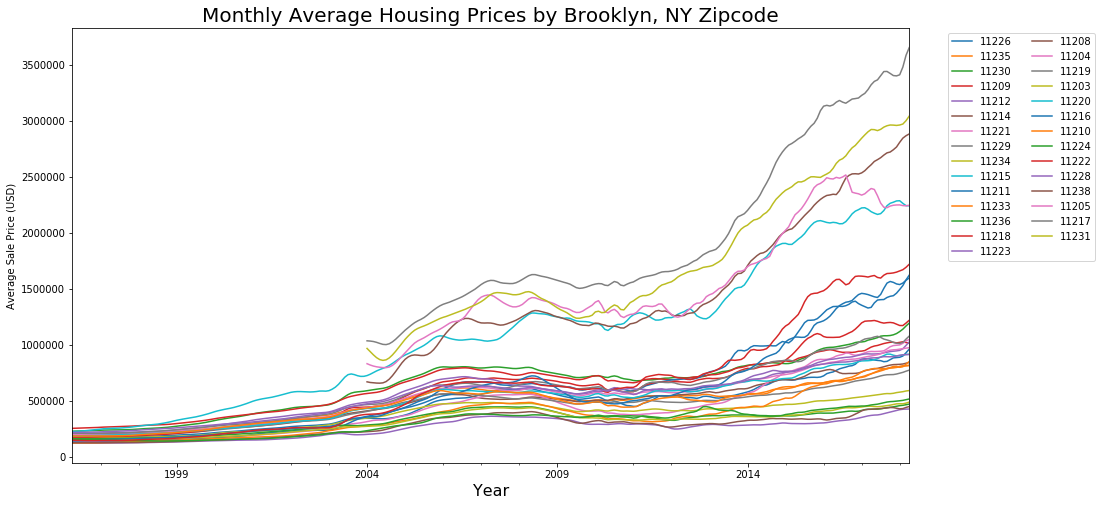

In [82]:
for zipcode in dfm.RegionName.unique():
    temp_df = dfm[dfm.RegionName == zipcode]
    temp_df['MeanValue'].plot(figsize = (15,8), label=zipcode)

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left', ncol=2)
plt.xlabel("Year", fontsize = 16)
plt.ylabel("Average Sale Price (USD)")
plt.title('Monthly Average Housing Prices by Brooklyn, NY Zipcode', fontsize = 20);


### Observations of the data:
- 25 zip codes have data from 1996 to 2018, however, 4 zip codes do not
- There was a dip in 2008 and 2010, housing price became stable around 2011.

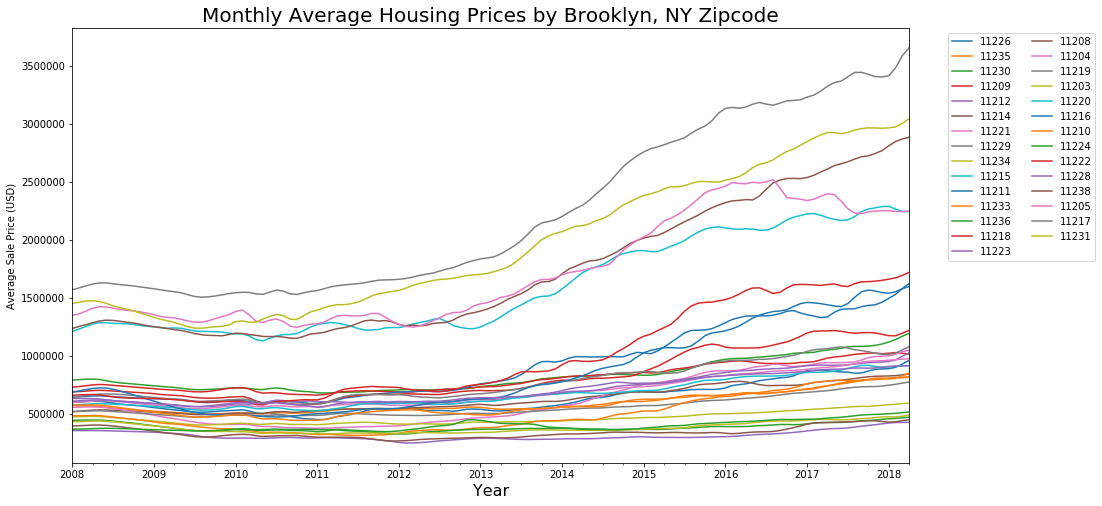

In [83]:
#A deeper look at 2008 above
for zipcode in dfm.RegionName.unique():
    temp_df = dfm[dfm.RegionName == zipcode]
    temp_df['2008':]['MeanValue'].plot(figsize = (15,8), label=zipcode)

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left', ncol=2)
plt.xlabel("Year", fontsize = 16)
plt.ylabel("Average Sale Price (USD)")
plt.title('Monthly Average Housing Prices by Brooklyn, NY Zipcode', fontsize = 20);


To get more accurate prediction on 2020 and onwards data,  we decided to use data 2011-Present. 

### Seasonal Decomposition for 2011 and Above

In [84]:
df2011 = dfm['2011':]
month_avg = df2011.groupby('Month')['MeanValue'].mean()

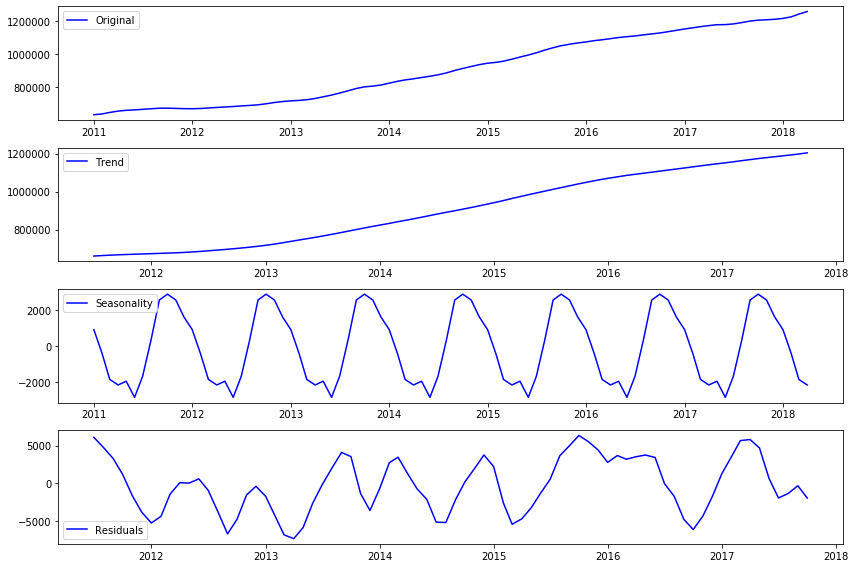

In [85]:
decomposition = sm.tsa.seasonal_decompose(month_avg, model='additive')

#Gather the trend, seasonality, and residualsbb
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(month_avg, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

An upward trend is present with yearly sesasonal changes. 

### Autocorrelation

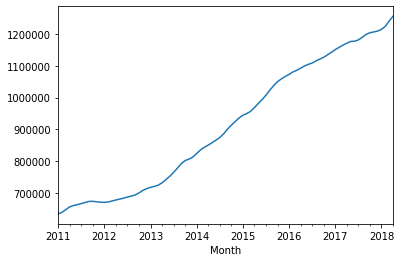

In [86]:
month_avg.plot()

#### The monthly average house price of Brooklyn increased year over year. No obvious autocorrelation and partial autocorrelation is present. 

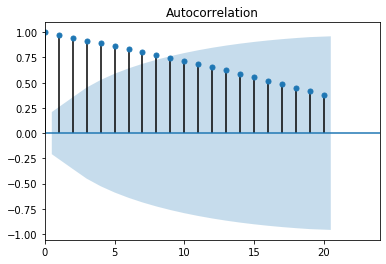

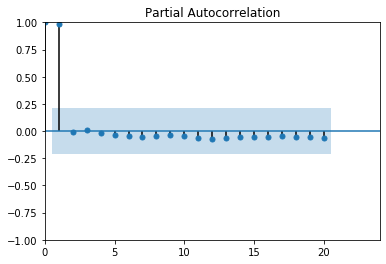

In [87]:
plot_acf(month_avg); plt.xlim(0,24); plt.show()
plot_pacf(month_avg); plt.xlim(0,24); plt.ylim(-1,1);plt.show()

#### If take lag = 3 difference. Autocorrlation appears.

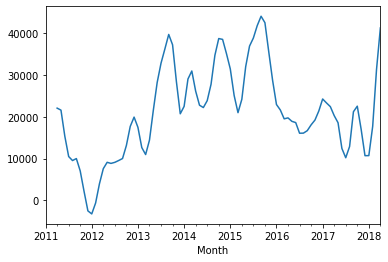

In [88]:
month_avg.diff(periods=3).plot()

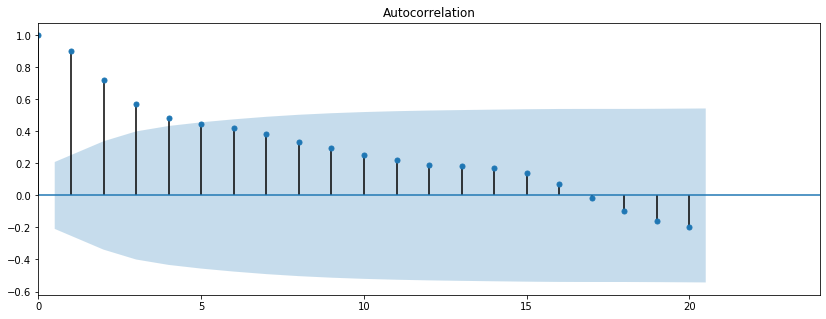

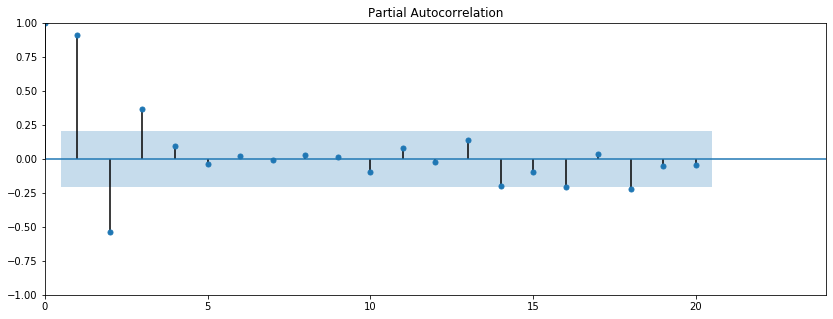

In [89]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5

plot_acf(month_avg.diff(periods=3).bfill()); plt.xlim(0,24); plt.show()
plot_pacf(month_avg.diff(periods=3).bfill()); plt.xlim(0,24); plt.ylim(-1,1);plt.show()

## Step 4: Initial SARIMA Models on Sample Zip Codes
<a id='005'></a>

In [90]:
dfm.RegionName.unique()

array([11226, 11235, 11230, 11209, 11212, 11214, 11221, 11229, 11234,
       11215, 11211, 11233, 11236, 11218, 11223, 11208, 11204, 11219,
       11203, 11220, 11216, 11210, 11224, 11222, 11228, 11238, 11205,
       11217, 11231], dtype=int64)

In [91]:
#Select 3 zipcodes
zip_dfs = []
zip_list = np.array([11231,11205,11217])
for x in zip_list:
    zip_dfs.append(pd.DataFrame(dfm[dfm['RegionName']==x][['MeanValue']].copy()))


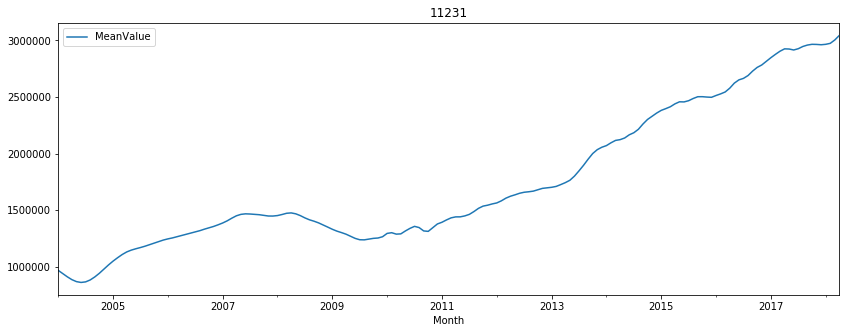

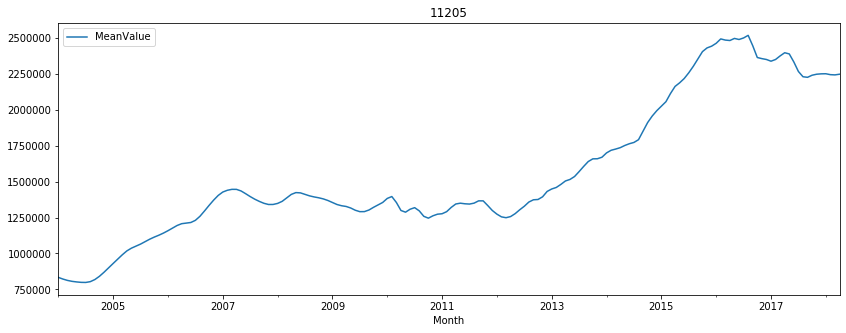

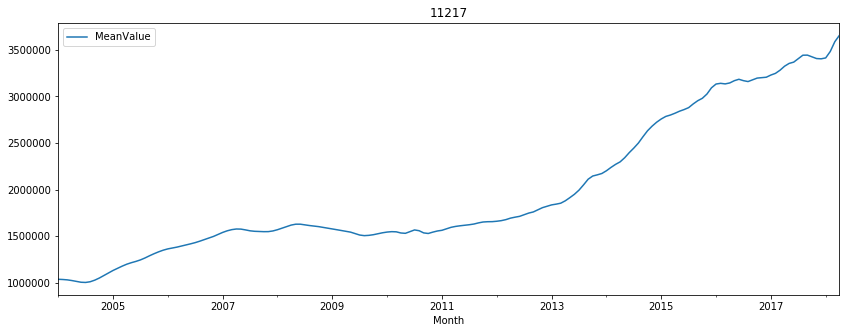

In [92]:
for df, name in zip(zip_dfs, zip_list):
    df.plot()
    plt.title(name)
    plt.show()

In [93]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,2)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p,d,q))
# Generate all different combinations of seasonal p, d and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [94]:
print(pdqs)

[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


In [95]:
#Run SARIMA
ans = []

for df, name in zip(zip_dfs, zip_list):
    for para1 in pdq:
        for para2 in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order = para1,
                                                seasonal_order = para2,
                                                enforce_stationarity = False,
                                                enforce_invertibility = False)
                output = mod.fit()
                ans.append([name, para1, para2, output.aic])
                print('Result for {}'.format(name) + ' ARIMA {} x {}12 : AIC Calculated = {}'.format(para1, para2, output.aic))
            except:
                continue

Result for 11231 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5423.9708093629815
Result for 11231 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4953.349711705396
Result for 11231 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4343.500124754707
Result for 11231 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3964.1793651985413
Result for 11231 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4224.726704777125
Result for 11231 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4167.708543674704
Result for 11231 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3911.0932416918577
Result for 11231 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3886.920566948442
Result for 11231 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5271.202299206424
Result for 11231 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4873.687909570232
Result for 11231 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4438.507909420632
Result for 11231 ARIMA (0, 0,

Result for 11205 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3479.5688364252333
Result for 11205 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3377.4131412999704
Result for 11205 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3330.5840562015533
Result for 11205 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3930.0629066955735
Result for 11205 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7230.066270143569
Result for 11205 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3762.733474314592
Result for 11205 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3485.3169023250784
Result for 11205 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3662.7909309470488
Result for 11205 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6730.9086402831235
Result for 11205 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3456.674123696707
Result for 11205 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3457.7007449292987
Result for 11205 ARIMA (

Result for 11217 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3467.8766918322717
Result for 11217 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3161.8845620785514
Result for 11217 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3359.650223736455
Result for 11217 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3339.898847141589
Result for 11217 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3183.4993831799698
Result for 11217 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3163.816347669034


In [96]:
result = pd.DataFrame(ans, columns = ['name','pdq','pdqs','AIC'])

In [97]:
best_para = result.loc[result.groupby("name")["AIC"].idxmin()]

In [98]:
best_para

,name,pdq,pdqs,AIC
127,11205,"(1, 1, 1)","(1, 1, 1, 12)",3275.267959
187,11217,"(1, 1, 1)","(0, 1, 1, 12)",3161.884562
63,11231,"(1, 1, 1)","(1, 1, 1, 12)",3114.322528


In [99]:
#Mean house price in Brooklyn is above $1 Million
dfm['2017':]['MeanValue'].mean()

1195787.9310344828

{'whiskers': [<matplotlib.lines.Line2D at 0x1d5a555df08>,
 'caps': [<matplotlib.lines.Line2D at 0x1d5a555fd88>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d5a555d888>],
 'medians': [<matplotlib.lines.Line2D at 0x1d5a555ff48>],
 'fliers': [<matplotlib.lines.Line2D at 0x1d5a5563fc8>],
 'means': []}

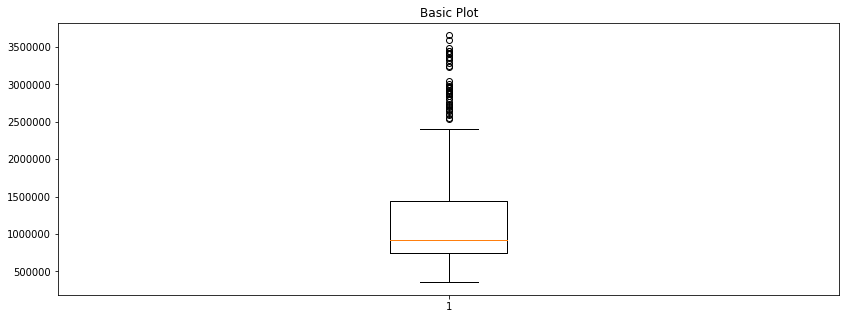

In [100]:
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(dfm['2017':]['MeanValue'])

### Plug the optimal parameter values into a new SARIMAX model to have a deeper look

In [101]:
# plug the optimal parameter values into a new SARIMAX model.

for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):
    
    ARIMA_MODEL = sm.tsa.SARIMAX(df, 
                           order = pdq,
                           seasonal_order = pdqs,
                           enforce_stationarity = False,
                           enforce_invertibility = False)
    
    output = ARIMA_MODEL.fit()
    print('SARIMA Model Result for {}'.format(name))
    print(output.summary().tables[1])
                           
                           
# Fit the model and print results

SARIMA Model Result for 11205
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7302      0.071     10.278      0.000       0.591       0.869
ma.L1          0.2318      0.033      7.053      0.000       0.167       0.296
ar.S.L12      -0.5738      0.086     -6.685      0.000      -0.742      -0.406
ma.S.L12      -0.0071      0.054     -0.131      0.895      -0.113       0.099
sigma2      1.344e+08   9.15e-11   1.47e+18      0.000    1.34e+08    1.34e+08
SARIMA Model Result for 11217
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4732      0.087      5.435      0.000       0.303       0.644
ma.L1          0.6258      0.064      9.720      0.000       0.500       0.752
ma.S.L12      -0.1747      0.043     -4.091      0.000      -0.258     

### Make dynamic forecast using data up to 2017-06-01 and compare with real values post 2017-06-01

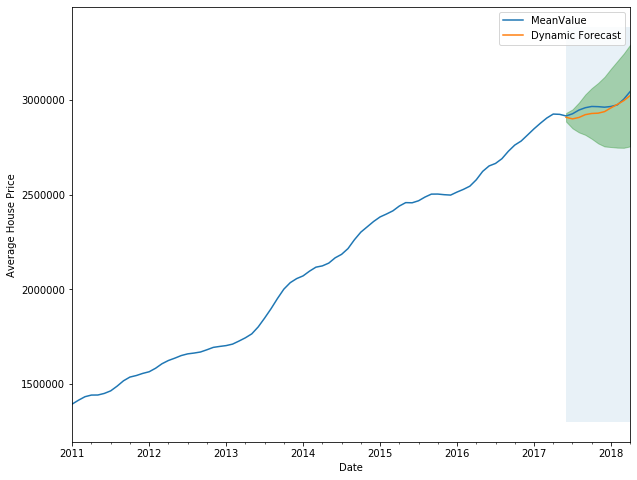

The Mean Squared Error of our forecasts is 25756.56


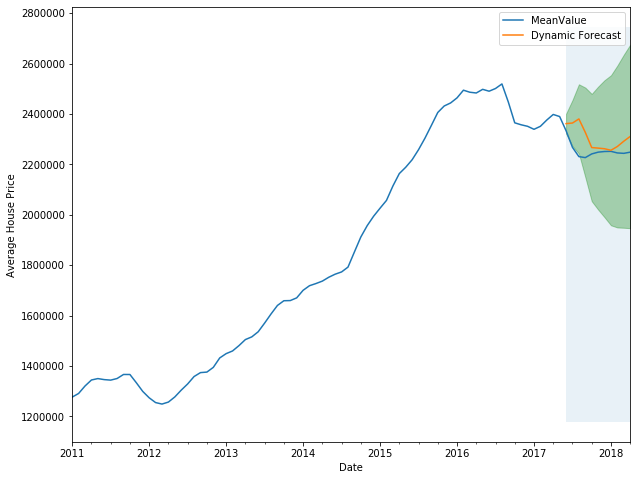

The Mean Squared Error of our forecasts is 67677.54


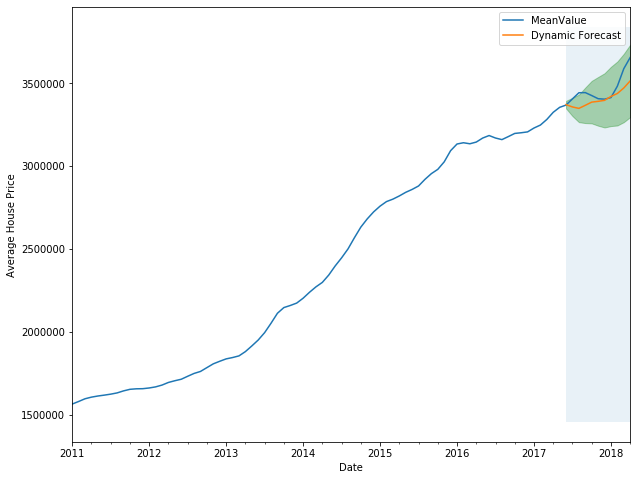

The Mean Squared Error of our forecasts is 70471.24


In [102]:
#Make Prediction post 2016 and compare with real values
summary_table = pd.DataFrame()
Zipcode = []
MSE_Value = []
models = []
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):

    ARIMA_MODEL = sm.tsa.SARIMAX(df,
                                 order = pdq,
                                 seasonal_order = pdqs,
                                 enforce_stationarity = False,
                                 enforce_invertibility = False)
                                
    output = ARIMA_MODEL.fit()
    models.append(output)
    
    #get dynamic predictions starting 2017-06-01
    pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-06-01'), dynamic = True, full_results = True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    zip_forecasted = pred_dynamic.predicted_mean
    zip_truth = df['2017-06-01':]['MeanValue']
    
    #Plot the dynamic forecast with confidence intervals as above
    ax = df['2011':].plot(label='observed', figsize=(10, 8))
    pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

    ax.fill_between(pred_dynamic_conf.index,
                    pred_dynamic_conf.iloc[:, 0],
                    pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

    ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-06-01'), zip_forecasted.index[-1], alpha=.1, zorder=-1)

    ax.set_xlabel('Date')
    ax.set_ylabel('Average House Price')

    plt.legend()
    plt.show()

    #print(type(zip_forecasted))
    #print(zip_truth)
    sqrt_mse = np.sqrt(((zip_forecasted - zip_truth)**2).mean())
    print('The Mean Squared Error of our forecasts is {}'.format(round(sqrt_mse, 2))) 
    
    Zipcode.append(name)
    MSE_Value.append(sqrt_mse)
    
summary_table['Zipcode'] = Zipcode
summary_table['Sqrt_MSE'] = MSE_Value
      

In [103]:
summary_table

,Zipcode,Sqrt_MSE
0,11205,25756.564490
1,11217,67677.540816
2,11231,70471.236969


### Producing and Visualizing Forecasts

In [104]:
forecast_table = pd.DataFrame()
current = []
forecast_3Yr = []
forecast_5Yr =[]
for zipcode, output, df in zip(Zipcode, models, zip_dfs):
    pred_3 = output.get_forecast(steps = 36)
    pred_conf_3 = pred_3.conf_int()
    forecast_3 = pred_3.predicted_mean.to_numpy()[-1]
    pred_5 = output.get_forecast(steps = 60)
    pred_conf_5 = pred_5.conf_int()
    forecast_5 = pred_5.predicted_mean.to_numpy()[-1]
    current.append(df['2018-04']['MeanValue'][0])
    forecast_3Yr.append(forecast_3)
    forecast_5Yr.append(forecast_5)

forecast_table['Zipcode'] = Zipcode
forecast_table['Current Value'] = current
forecast_table['3 Years Value'] = forecast_3Yr
forecast_table['5 Years Value'] = forecast_5Yr
forecast_table['3Yr-ROI']=(forecast_table['3 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI']=(forecast_table['5 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']

In [105]:
forecast_table

,Zipcode,Current Value,3 Years Value,5 Years Value
0,11205,3044500.0,3.764785e+06,4.209853e+06
1,11217,2248400.0,1.826419e+06,1.547083e+06
2,11231,3656000.0,4.669342e+06,5.344744e+06


## Step 5: SARIMA models on all Zipcodes 
<a id='006'></a>

In [108]:
zip_dfs = []
zip_list = dfm.RegionName.unique()
for x in zip_list:
    zip_dfs.append(pd.DataFrame(dfm[dfm['RegionName']==x][['MeanValue']].copy()))
    

In [109]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,2)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p,d,q))
# Generate all different combinations of seasonal p, d and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [110]:
#Run SARIMA
start=time.time()
ans = []

for df, name in zip(zip_dfs, zip_list):
    for para1 in pdq:
        for para2 in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order = para1,
                                                seasonal_order = para2,
                                                enforce_stationarity = False,
                                                enforce_invertibility = False)
                output = mod.fit()
                ans.append([name, para1, para2, output.aic])
                print('Result for {}'.format(name) + ' ARIMA {} x {}12 : AIC Calculated = {}'.format(para1, para2, output.aic))
            except:
                continue
                


Result for 11226 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7686.987458773749
Result for 11226 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 341140.6252092148
Result for 11226 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6252.839047360809
Result for 11226 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5938.6516920417425
Result for 11226 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6176.700787594302
Result for 11226 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6151.121734546192
Result for 11226 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5927.154967620481
Result for 11226 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5965.399946458674
Result for 11226 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7467.09129659485
Result for 11226 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 315115.9964361352
Result for 11226 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6053.0584734647
Result for 11226 ARIMA (0, 0, 1) x

Result for 11235 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4503.540506987307
Result for 11235 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4443.891365558282
Result for 11235 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5102.746835235477
Result for 11235 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4844.661296941101
Result for 11235 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4926.0615095162075
Result for 11235 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4706.367693618155
Result for 11235 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4844.640586090194
Result for 11235 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4903.7447159490985
Result for 11235 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4690.997395352189
Result for 11235 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4695.80105163493
Result for 11235 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4854.6124799599775
Result for 11235 ARIMA (1, 0, 

Result for 11230 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4591.886732641861
Result for 11230 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4527.18588274823
Result for 11230 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4485.037253656677
Result for 11209 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7836.416695287651
Result for 11209 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7326.841495061542
Result for 11209 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6231.044773562101
Result for 11209 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5947.055045802393
Result for 11209 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6152.510623937484
Result for 11209 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6108.24842976807
Result for 11209 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5815.852252312929
Result for 11209 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5791.673158201202
Result for 11209 ARIMA (0, 0, 1) x

Result for 11212 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4382.87423182958
Result for 11212 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4478.828129642085
Result for 11212 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4436.910897146433
Result for 11212 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4432.388341728815
Result for 11212 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4374.590017944608
Result for 11212 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4965.979998370826
Result for 11212 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4881.873919875104
Result for 11212 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4864.504471005228
Result for 11212 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4650.611463714452
Result for 11212 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4744.992980202445
Result for 11212 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4746.299484317662
Result for 11212 ARIMA (1, 0, 0) 

Result for 11214 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4405.264423649534
Result for 11214 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4679.088756528376
Result for 11214 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4346.326118270863
Result for 11214 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4419.026859501044
Result for 11214 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4406.821652139746
Result for 11214 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4399.727489084574
Result for 11214 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4353.273127952528
Result for 11221 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7680.992324686582
Result for 11221 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 229765.1349341699
Result for 11221 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6354.75101263223
Result for 11221 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 6065.366560167788
Result for 11221 ARIMA (0, 0, 0) 

Result for 11229 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4610.493917738719
Result for 11229 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4592.7655722321015
Result for 11229 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4868.047438706519
Result for 11229 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4520.824100836166
Result for 11229 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4670.016467258882
Result for 11229 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4387.257531879068
Result for 11229 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4609.710319143909
Result for 11229 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4521.905449208643
Result for 11229 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4423.952062323675
Result for 11229 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4345.343690501331
Result for 11229 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5028.5891224568095
Result for 11229 ARIMA (1, 0, 

Result for 11234 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4327.898538640641
Result for 11234 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4256.23644530305
Result for 11234 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4259.239469712977
Result for 11234 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4464.346522645867
Result for 11234 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4213.7084967912915
Result for 11234 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4464.31759824328
Result for 11234 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4158.998968328469
Result for 11234 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4263.540431859986
Result for 11234 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4215.013227151525
Result for 11234 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4198.103668038304
Result for 11234 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4144.538560363038
Result for 11215 ARIMA (0, 0, 0) 

Result for 11211 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5208.899586466339
Result for 11211 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5459.162097042283
Result for 11211 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5426.444188638232
Result for 11211 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5167.376368750434
Result for 11211 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5138.295655749485
Result for 11211 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5419.857667551502
Result for 11211 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5196.8690833232795
Result for 11211 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5396.661190077572
Result for 11211 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5022.9178319101375
Result for 11211 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5236.960739879175
Result for 11211 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5198.798625092813
Result for 11211 ARIMA (0, 1, 

Result for 11233 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4898.662864209888
Result for 11233 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4630.4884194459155
Result for 11233 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4739.30248578776
Result for 11233 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4741.220024232045
Result for 11233 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4605.183938852724
Result for 11233 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4606.249964884846
Result for 11233 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4905.256172525664
Result for 11233 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4677.491729085428
Result for 11233 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4837.887256884041
Result for 11233 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4550.500109284578
Result for 11233 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4696.591068280176
Result for 11233 ARIMA (1, 1, 1)

Result for 11218 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5099.341633613789
Result for 11218 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5308.5002761277065
Result for 11218 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5287.892679710238
Result for 11218 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5103.681948550252
Result for 11218 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5068.039786768644
Result for 11218 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5284.327348973021
Result for 11218 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5050.88831032993
Result for 11218 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5218.081723212324
Result for 11218 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4952.364177519603
Result for 11218 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5064.882870690457
Result for 11218 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5052.877833136389
Result for 11218 ARIMA (0, 1, 1)

Result for 11223 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4855.341333726194
Result for 11223 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4593.016945361202
Result for 11223 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4640.74877429831
Result for 11223 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4641.802905107143
Result for 11223 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4567.0740853041925
Result for 11223 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4566.725638180467
Result for 11223 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4810.001761780467
Result for 11223 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4530.28444422072
Result for 11223 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4808.861874932902
Result for 11223 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4480.865957904129
Result for 11223 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4557.174930458351
Result for 11223 ARIMA (1, 1, 1) 

Result for 11204 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4955.072691110869
Result for 11204 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4694.650779090972
Result for 11204 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4920.621639099521
Result for 11204 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4898.9647176720355
Result for 11204 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4691.914341553102
Result for 11204 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4674.150305178398
Result for 11204 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4885.897715967122
Result for 11204 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4633.70940180372
Result for 11204 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4887.789494642748
Result for 11204 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4471.925717946055
Result for 11204 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4706.515042373385
Result for 11204 ARIMA (0, 1, 1)

Result for 11219 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5006.96171547982
Result for 11219 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4736.240571927256
Result for 11219 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4816.388035413788
Result for 11219 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4817.016083455635
Result for 11219 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4714.168506018624
Result for 11219 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4713.758669550637
Result for 11219 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4973.623383882552
Result for 11219 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4682.974989094384
Result for 11219 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4943.446525258195
Result for 11219 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4620.908913377509
Result for 11219 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4705.934507664035
Result for 11219 ARIMA (1, 1, 1) 

Result for 11220 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5172.550974556616
Result for 11220 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4866.456826035474
Result for 11220 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5065.51026988877
Result for 11220 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5043.423774776263
Result for 11220 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4813.838468190825
Result for 11220 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4794.872207160299
Result for 11220 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5032.600570665436
Result for 11220 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4810.204672620914
Result for 11220 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4990.5444638180425
Result for 11220 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4702.933843348906
Result for 11220 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4849.3870727562935
Result for 11220 ARIMA (0, 1, 1

Result for 11216 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5256.092471729116
Result for 11216 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4941.416193157518
Result for 11216 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5005.792152870959
Result for 11216 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5007.788423504188
Result for 11216 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4896.049791317479
Result for 11216 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4896.597064568102
Result for 11216 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5439.991943318936
Result for 11216 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4897.5766363152925
Result for 11216 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5207.370323215237
Result for 11216 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4808.8522973058025
Result for 11216 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4930.744481776627
Result for 11216 ARIMA (1, 1, 

Result for 11224 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4761.527595996329
Result for 11224 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4905.624809684377
Result for 11224 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4890.308559984143
Result for 11224 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4771.723156023763
Result for 11224 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4737.969502673273
Result for 11224 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4841.515884336851
Result for 11224 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4630.7721205452035
Result for 11224 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4928.816612673172
Result for 11224 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4544.0225892582375
Result for 11224 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4666.247368695391
Result for 11224 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4632.77147843254
Result for 11224 ARIMA (0, 1, 1

Result for 11222 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5388.016477511096
Result for 11222 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5053.56558168557
Result for 11222 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5131.873212502513
Result for 11222 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5118.891066851215
Result for 11222 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5043.996700823129
Result for 11222 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5034.797407070118
Result for 11222 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5294.319000590889
Result for 11222 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5009.84731779472
Result for 11222 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5282.443710308704
Result for 11222 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4950.360257137092
Result for 11222 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5049.242994436039
Result for 11222 ARIMA (1, 1, 1) x

Result for 11238 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3299.5448768891897
Result for 11238 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3563.1771934554595
Result for 11238 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3535.221577203555
Result for 11238 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3304.6890990086004
Result for 11238 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3284.7551299170154
Result for 11238 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3708.246955314492
Result for 11238 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3435.183572354721
Result for 11238 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3541.7440919747187
Result for 11238 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3180.504238209928
Result for 11238 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3487.954157800252
Result for 11238 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3437.1735685673157
Result for 11238 ARIMA (0,

Result for 11205 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3347.4989981611607
Result for 11205 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3502.2621481257047
Result for 11205 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3503.8677836841125
Result for 11205 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3324.1196088102033
Result for 11205 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3325.018436325903
Result for 11205 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3722.847528438273
Result for 11205 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3428.3833868125685
Result for 11205 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3604.63717285738
Result for 11205 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3287.5722778802387
Result for 11205 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3450.8221875264126
Result for 11205 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3425.3164565489005
Result for 11205 ARIMA (1

Result for 11231 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3298.557377541805
Result for 11231 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3571.7301436694715
Result for 11231 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3545.787247456936
Result for 11231 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3305.4054377810953
Result for 11231 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3286.5434875354804
Result for 11231 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3691.4084416183678
Result for 11231 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3419.4010815046468
Result for 11231 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3565.5281510856203
Result for 11231 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3177.368616245627
Result for 11231 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3469.9512896516535
Result for 11231 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3421.400120323722
Result for 11231 ARIMA (0

In [111]:
print('Took', time.time()-start, 'seconds.')

Took 1155.1124148368835 seconds.


In [112]:
result = pd.DataFrame(ans, columns = ['name','pdq','pdqs','AIC'])

In [113]:
best_para = result.loc[result.groupby("name")["AIC"].idxmin()]

In [119]:
best_para.head()

,name,pdq,pdqs,AIC
1215,11203,"(1, 1, 1)","(1, 1, 1, 12)",4180.766192
1083,11204,"(1, 1, 1)","(0, 1, 1, 12)",4286.602865
1727,11205,"(1, 1, 1)","(1, 1, 1, 12)",3275.267959
1023,11208,"(1, 1, 1)","(1, 1, 1, 12)",4250.901034
255,11209,"(1, 1, 1)","(1, 1, 1, 12)",4585.735786


In [115]:
# plug the optimal parameter values into a new SARIMAX model.
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):
    
    ARIMA_MODEL = sm.tsa.SARIMAX(df, 
                           order = pdq,
                           seasonal_order = pdqs,
                           enforce_stationarity = False,
                           enforce_invertibility = False)
    
    output = ARIMA_MODEL.fit()
                             
# Fit the model and print results

### Make dynamic forecast using data up to 2017-06-01 and compare with real values post 2017-06-01

In [116]:
#Make Prediction post 2016 and compare with real values
summary_table = pd.DataFrame()
Zipcode = []
MSE_Value = []
models = []
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):

    
    ARIMA_MODEL = sm.tsa.SARIMAX(df,
                                 order = pdq,
                                 seasonal_order = pdqs,
                                 enforce_stationarity = False,
                                 enforce_invertibility = False,
                                 )
                                
    
    output = ARIMA_MODEL.fit()
    models.append(output)
    
    #get dynamic predictions starting 2017-06-01
    pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-06-01'), dynamic = True, full_results = True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    zip_forecasted = pred_dynamic.predicted_mean
    zip_truth = df['2017-06-01':]['MeanValue']
    
    sqrt_mse = np.sqrt(((zip_forecasted - zip_truth)**2).mean())
    
    Zipcode.append(name)
    MSE_Value.append(sqrt_mse)
    
summary_table['Zipcode'] = Zipcode
summary_table['Sqrt_MSE'] = MSE_Value
        

In [120]:
#Get the MSE
summary_table.head()

,Zipcode,Sqrt_MSE
0,11203,18069.990188
1,11204,9762.473910
2,11205,23736.639608
3,11208,17348.540336
4,11209,17823.848027


In [131]:
#Final Model 
forecast_table = pd.DataFrame()
current = []
forecast_3Yr = []
forecast_5Yr =[]
conf_3Yr_L=[]
conf_3Yr_U=[]
conf_5Yr_L=[]
conf_5Yr_U=[]
for zipcode, output, df in zip(Zipcode, models, zip_dfs):
    pred_3 = output.get_forecast(steps = 36)
    pred_conf_3 = pred_3.conf_int()
    forecast_3 = pred_3.predicted_mean.to_numpy()[-1]
    
    pred_5 = output.get_forecast(steps = 60)
    pred_conf_5 = pred_5.conf_int()
    forecast_5 = pred_5.predicted_mean.to_numpy()[-1]
    current.append(df['2018-04']['MeanValue'][0])
    
    forecast_3Yr.append(forecast_3)
    conf_3Yr_L.append(pred_conf_3.iloc[:, 0][-1])
    conf_3Yr_U.append(pred_conf_3.iloc[:, 1][-1])
    forecast_5Yr.append(forecast_5)
    conf_5Yr_L.append(pred_conf_5.iloc[:, 0][-1])
    conf_5Yr_U.append(pred_conf_5.iloc[:, 1][-1])

forecast_table['Zipcode'] = Zipcode
forecast_table['Current Value'] = current
forecast_table['3 Years Value'] = forecast_3Yr
forecast_table['5 Years Value'] = forecast_5Yr
forecast_table['3 Years Lower'] = conf_3Yr_L
forecast_table['3 Years Upper'] = conf_3Yr_U
forecast_table['5 Years Lower'] = conf_5Yr_L
forecast_table['5 Years Upper'] = conf_5Yr_U

forecast_table['3Yr-ROI']=(forecast_table['3 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI']=(forecast_table['5 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['3Yr-ROI-Lower']=(forecast_table['3 Years Lower'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['3Yr-ROI-Upper']=(forecast_table['3 Years Upper'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI-Lower']=(forecast_table['5 Years Lower'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI-Upper']=(forecast_table['5 Years Upper'] - forecast_table['Current Value'])/forecast_table['Current Value']

forecast_table.head()

,Zipcode,Current Value,3 Years Value,5 Years Value,3 Years Lower,3 Years Upper,5 Years Lower,5 Years Upper,3Yr-ROI,5Yr-ROI,3Yr-ROI-Lower,3Yr-ROI-Upper,5Yr-ROI-Lower,5Yr-ROI-Upper
0,11203,963200.0,1.379875e+06,1.642406e+06,1.040545e+06,1.719205e+06,1.003086e+06,2.281727e+06,0.432594,0.705156,0.080300,0.784889,0.041409,1.368903
1,11204,816200.0,1.003541e+06,1.129669e+06,7.852411e+05,1.221842e+06,7.002434e+05,1.559094e+06,0.229529,0.384059,-0.037931,0.496988,-0.142069,0.910186
2,11205,1195400.0,1.765556e+06,2.139029e+06,1.393440e+06,2.137671e+06,1.398717e+06,2.879340e+06,0.476958,0.789383,0.165669,0.788248,0.170083,1.408684
3,11208,1015800.0,1.051716e+06,1.081514e+06,7.387346e+05,1.364697e+06,4.790525e+05,1.683976e+06,0.035357,0.064692,-0.272756,0.343471,-0.528399,0.657783
4,11209,428400.0,5.475360e+05,6.276379e+05,3.126358e+05,7.824362e+05,1.761102e+05,1.079166e+06,0.278095,0.465074,-0.270225,0.826415,-0.588912,1.519061


In [128]:
forecast_table['3 Years Value Lower Limit'][0]

1040544.5699094619

### Top 5 Zip codes with Highest 3Yr-ROI

In [132]:
forecast_table.sort_values('3Yr-ROI', ascending = False)[0:5]

,Zipcode,Current Value,3 Years Value,5 Years Value,3 Years Lower,3 Years Upper,5 Years Lower,5 Years Upper,3Yr-ROI,5Yr-ROI,3Yr-ROI-Lower,3Yr-ROI-Upper,5Yr-ROI-Lower,5Yr-ROI-Upper
14,11220,1026600.0,1.562324e+06,1.906698e+06,1.203992e+06,1.920656e+06,1.196597e+06,2.616800e+06,0.521843,0.857294,0.172796,0.870891,0.165592,1.548996
2,11205,1195400.0,1.765556e+06,2.139029e+06,1.393440e+06,2.137671e+06,1.398717e+06,2.879340e+06,0.476958,0.789383,0.165669,0.788248,0.170083,1.408684
0,11203,963200.0,1.379875e+06,1.642406e+06,1.040545e+06,1.719205e+06,1.003086e+06,2.281727e+06,0.432594,0.705156,0.080300,0.784889,0.041409,1.368903
18,11224,489900.0,6.746460e+05,7.925614e+05,4.872264e+05,8.620656e+05,4.230197e+05,1.162103e+06,0.377110,0.617802,-0.005457,0.759677,-0.136518,1.372123
11,11217,852300.0,1.138072e+06,1.324995e+06,9.043490e+05,1.371795e+06,8.833630e+05,1.766627e+06,0.335295,0.554611,0.061069,0.609522,0.036446,1.072775


### Top 5 Zip codes with Highest 5Yr-ROI

In [133]:
forecast_table.sort_values('5Yr-ROI', ascending = False)[0:5]

,Zipcode,Current Value,3 Years Value,5 Years Value,3 Years Lower,3 Years Upper,5 Years Lower,5 Years Upper,3Yr-ROI,5Yr-ROI,3Yr-ROI-Lower,3Yr-ROI-Upper,5Yr-ROI-Lower,5Yr-ROI-Upper
14,11220,1026600.0,1.562324e+06,1.906698e+06,1.203992e+06,1.920656e+06,1.196597e+06,2.616800e+06,0.521843,0.857294,0.172796,0.870891,0.165592,1.548996
2,11205,1195400.0,1.765556e+06,2.139029e+06,1.393440e+06,2.137671e+06,1.398717e+06,2.879340e+06,0.476958,0.789383,0.165669,0.788248,0.170083,1.408684
0,11203,963200.0,1.379875e+06,1.642406e+06,1.040545e+06,1.719205e+06,1.003086e+06,2.281727e+06,0.432594,0.705156,0.080300,0.784889,0.041409,1.368903
18,11224,489900.0,6.746460e+05,7.925614e+05,4.872264e+05,8.620656e+05,4.230197e+05,1.162103e+06,0.377110,0.617802,-0.005457,0.759677,-0.136518,1.372123
11,11217,852300.0,1.138072e+06,1.324995e+06,9.043490e+05,1.371795e+06,8.833630e+05,1.766627e+06,0.335295,0.554611,0.061069,0.609522,0.036446,1.072775


## Step 6: Interpret the Results
<a id='007'></a>

Based on 3 year return on investment and 5 year return on investment, below 5 zipcodes stand out to be best area to invest in. South Sunset Park, Clinton Hill, East Flatbush and Boerum Hill have a guaranteed positive ROI and could be as high as 87% in 3 years and 154% in 5 years. However Coney Island has the risk of decreasing price because it is relatively far from the main city and the value depends on more factors such as development, facilities around the neighbourhood and transportation. 

- 11220: South Sunset Park (3Yr ROI: 17%-87%; 5Yr ROI: 16%-154%)
- 11205: Clinton Hill (3Yr ROI: 16%-78%; 5Yr ROI: 17%-140%)
- 11203: East Flatbush (3Yr ROI: 8%-78%; 5Yr ROI: 4%-136%)
- 11224: Coney Island (3Yr ROI: -0.5%-76%; 5Yr ROI: -13%-137%)
- 11217: Boerum Hill (3Yr ROI: 6%-61%; 5Yr ROI: 3%-107%)

However, other factors need to be taken into consideration due to the limit of the time series models, such as transportation, public safety, number of new constructions in the area, and school district etc. 

<img src="brooklyn_5_best_zip.jpg">